In [1]:
# This is a set of scripts to explore a MVPA analysis with Smith and Wang
# Python 2
# First thing is importing the libraries
import nilearn
from nilearn import datasets,image,masking,signal,plotting,input_data
import numpy as np
import pandas as pd
import sklearn as skl
import os
import matplotlib.pyplot as plt
os.chdir('../')


/usr/local/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Python2 support is deprecated and will be removed in a future release. Consider switching to Python3.
  after removing the cwd from sys.path.
/usr/local/anaconda2/lib/python2.7/site-packages/sklearn/utils/graph.py:15: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .graph_shortest_path import graph_shortest_path  # noqa
/usr/local/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/base.py:35: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ..utils.seq_dataset impo

In [2]:
#Second thing is getting the data
# Gonna download 2 sets of masks that we may use
sub_cort_HO=datasets.fetch_atlas_harvard_oxford(
    'sub-prob-2mm')
pauli=datasets.fetch_atlas_pauli_2017()
#List of z_images
func_list=[]
label_list=[]
#List of labels
sublist=os.listdir('data')
for sub in sublist:
    print sub
    func_list.append('data/%s/%s_func.nii.gz'%(sub,sub))
    label_list.append(
        pd.read_csv('data/%s/%s_labels.csv'%(sub,sub)
                   ,sep='\t',index_col=0,names=['trial','choice','feedback','idk','type','run']))
    
for df in label_list:
    df['high_low']=df.apply(lambda row: np.greater(row['feedback'],2.5),axis=1 )
    df['quantile']=pd.qcut(df['feedback'].astype(float),4,labels=False)
df['quantile']=df['quantile']+1
display(df)

sub-119
sub-118
sub-107
sub-113
sub-106
sub-112
sub-125
sub-123
sub-108
sub-111
sub-115
sub-117
sub-120
sub-116
sub-114
sub-109
sub-121
sub-122
sub-104
sub-110


,trial,choice,feedback,idk,type,run,high_low,quantile
NaN,0.0,1.0,2.000000,3.0,type,run,False,2
0.0,1.0,2.0,2.000000,0.0,i,1,False,2
1.0,2.0,2.0,2.000000,0.0,i,1,False,2
2.0,3.0,2.0,0.000000,1.0,i,1,False,1
3.0,4.0,2.0,0.000000,1.0,i,1,False,1
4.0,5.0,2.0,2.000000,0.0,i,1,False,2
5.0,6.0,2.0,0.000000,1.0,i,1,False,1
6.0,7.0,2.0,2.321928,0.0,i,1,False,3
7.0,8.0,2.0,2.321928,0.0,i,1,False,3
8.0,9.0,2.0,2.321928,0.0,i,1,False,3


Here we verify that everything is looking normal for one subject
sub-119
data/sub-119/sub-119_func.nii.gz


,trial,choice,feedback,idk,type,run,high_low,quantile
NaN,0.0,1.0,2.0,3.0,type,run,False,1
0.0,1.0,1.0,3.0,0.0,a,1,True,2
1.0,2.0,1.0,1.0,0.0,a,1,False,0
2.0,3.0,1.0,2.0,0.0,a,1,False,1
3.0,4.0,1.0,2.0,0.0,a,1,False,1


 The areas in the pauli 2017 atlas are ['Pu', 'Ca', 'NAC', 'EXA', 'GPe', 'GPi', 'SNc', 'RN', 'SNr', 'PBP', 'VTA', 'VeP', 'HN', 'HTH', 'MN', 'STH']


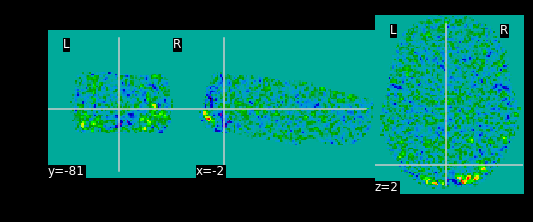

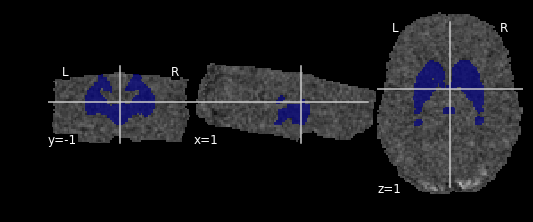

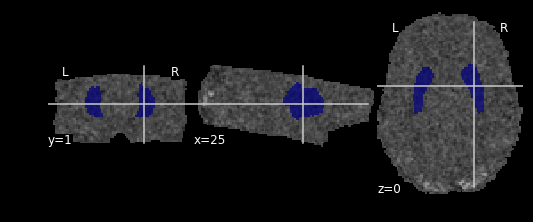

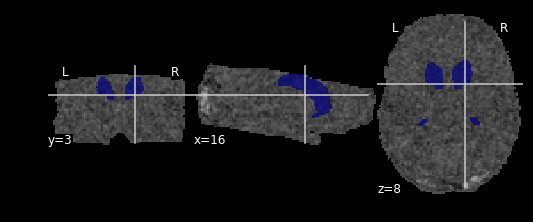

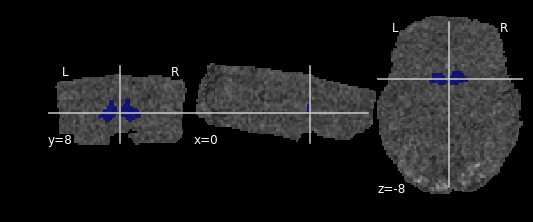

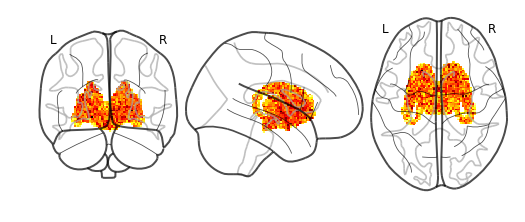

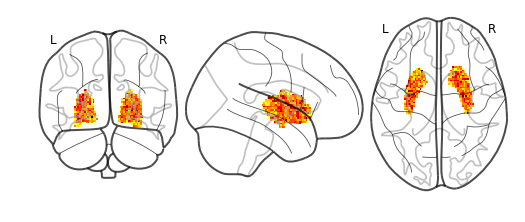

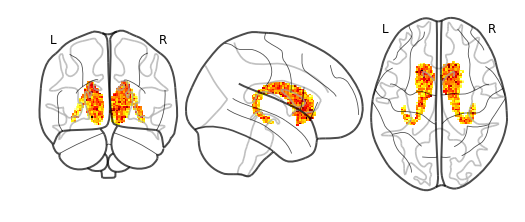

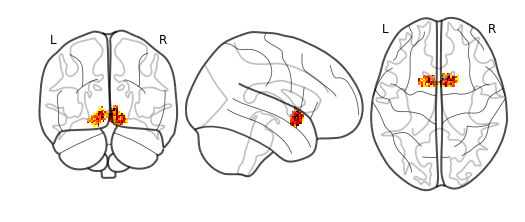

In [3]:
#Let's check out our data and masks
#the behavioral is hopefully easiest to verify
print("Here we verify that everything is looking normal for one subject")
print(sublist[0])
#we can check manually if we want that
#this is correct. It is
print(func_list[0])
display(label_list[0].head())
print(" The areas in the pauli 2017 atlas are %s"%(pauli.labels))
func=image.load_img(func_list[0])
mean_img=image.image.mean_img(func)
plotting.plot_epi(mean_img)
small_mask=masking.compute_background_mask(
    image.resample_to_img(pauli.maps,mean_img,interpolation='linear'))

res_put=masking.compute_background_mask(
    image.resample_to_img(image.index_img(pauli.maps,0),mean_img,interpolation='linear'))

res_caud=masking.compute_background_mask(
    image.resample_to_img(image.index_img(pauli.maps,1),mean_img,interpolation='linear'))

res_Nac=masking.compute_background_mask(
    image.resample_to_img(image.index_img(pauli.maps,2),mean_img,interpolation='linear'))

plotting.plot_roi(small_mask,mean_img)
plotting.plot_roi(res_put,mean_img)
plotting.plot_roi(res_caud,mean_img)
plotting.plot_roi(res_Nac,mean_img)

#make a few different maskers for full subcortex of interest and sub areas
full_pauli_masker=input_data.NiftiMasker(mask_img=small_mask, standardize=False)
Put_masker=input_data.NiftiMasker(mask_img=res_put,standardize=False)
                                            
Caud_masker=input_data.NiftiMasker(mask_img=res_caud,standardize=False)
                                   
NAc_masker=input_data.NiftiMasker(mask_img=res_Nac,standardize=False)

maskers=[full_pauli_masker,Put_masker,Caud_masker,NAc_masker]

#look at all the masked images they make
masked_img=full_pauli_masker.fit_transform(image.index_img(func,1))
Put_masked_img=Put_masker.fit_transform(image.index_img(func,1))
Caud_masked_img=Caud_masker.fit_transform(image.index_img(func,1))
NAc_masked_img=NAc_masker.fit_transform(image.index_img(func,1))

plotting.plot_glass_brain(image.image.mean_img(
        full_pauli_masker.inverse_transform(masked_img)))
plotting.plot_glass_brain(image.image.mean_img(
        Put_masker.inverse_transform(Put_masked_img)))
plotting.plot_glass_brain(image.image.mean_img(
        Caud_masker.inverse_transform(Caud_masked_img)))
plotting.plot_glass_brain(image.image.mean_img(
        NAc_masker.inverse_transform(NAc_masked_img)))
plt.show()

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:22: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .linbin import fast_linbin
/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:11: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._smoothers_lowess import lowess as _lowess
/usr/local/anaconda2/lib/python2.7/site-packages/scipy/cluster/vq.py:78: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _vq
/usr/local/anaconda2/lib/python2.7/site-packages/scipy/cluster/hierarchy.py:178: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _hierarchy, _optimal_leaf_ordering


sub-119 data/sub-119/sub-119_func.nii.gz
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM

run
1    [a]
2    [i]
3    [a]
4    [i]
Name: type, dtype: object

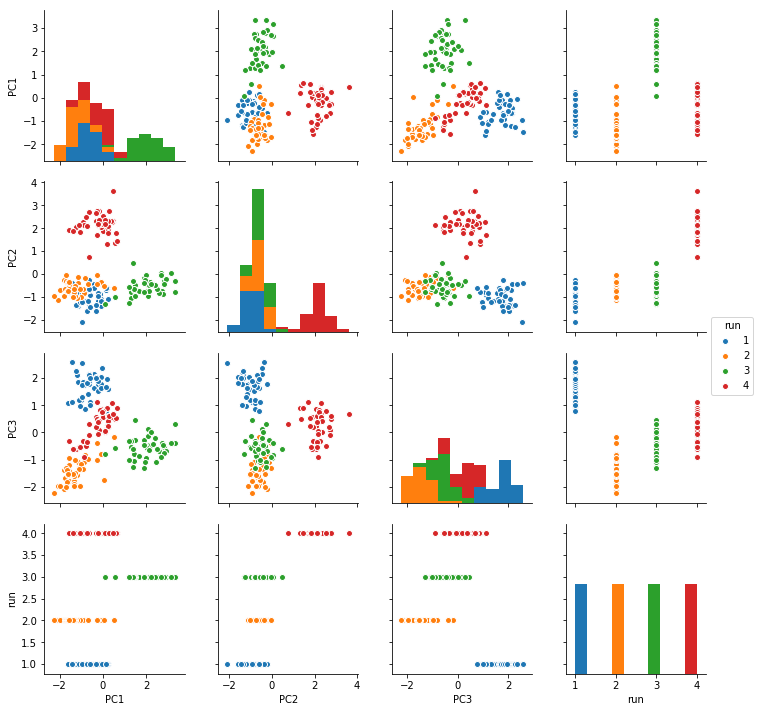

sub-118 data/sub-118/sub-118_func.nii.gz
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM

run
1    [i]
2    [a]
3    [i]
4    [a]
Name: type, dtype: object

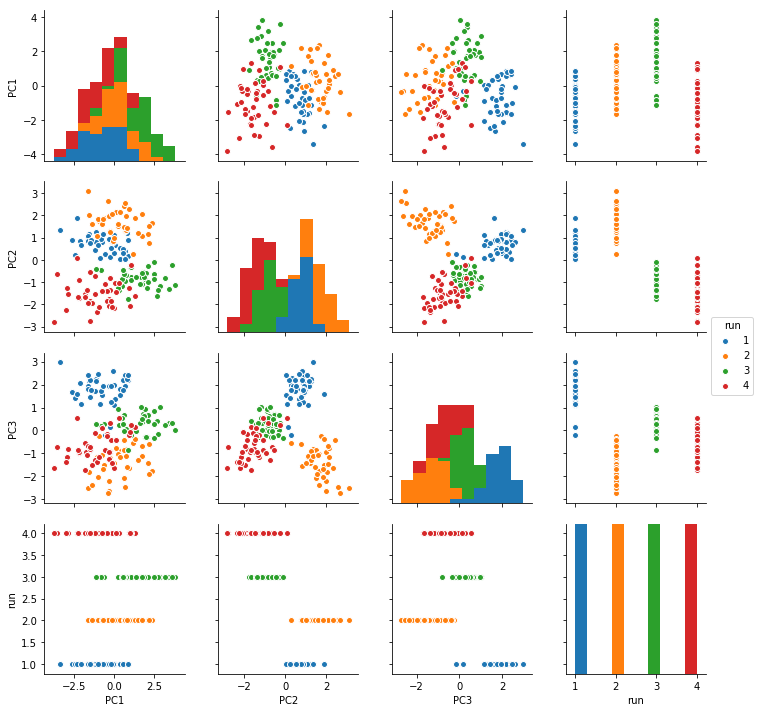

sub-107 data/sub-107/sub-107_func.nii.gz
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM

run
1    [a]
2    [i]
3    [a]
4    [i]
Name: type, dtype: object

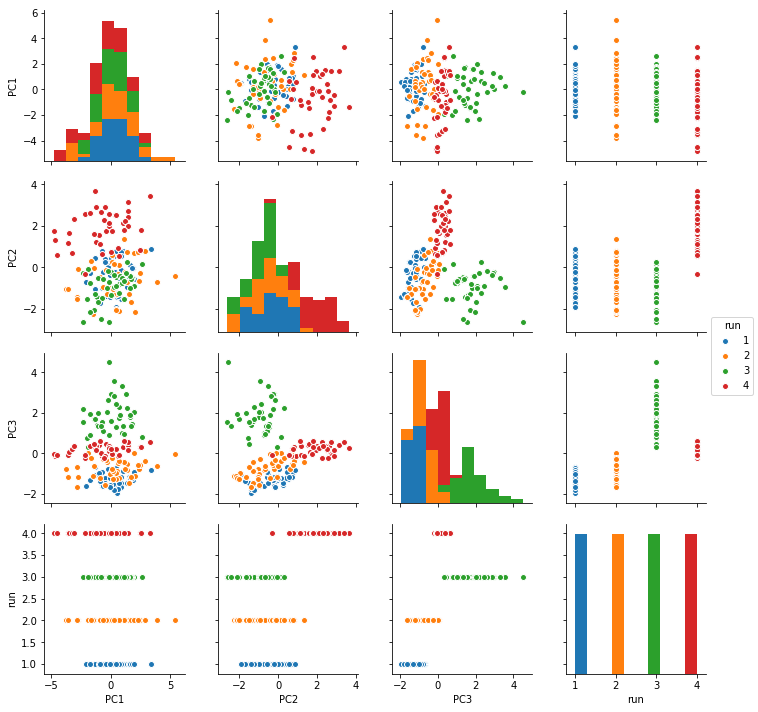

sub-113 data/sub-113/sub-113_func.nii.gz
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM

run
1    [a]
2    [i]
3    [a]
4    [i]
Name: type, dtype: object

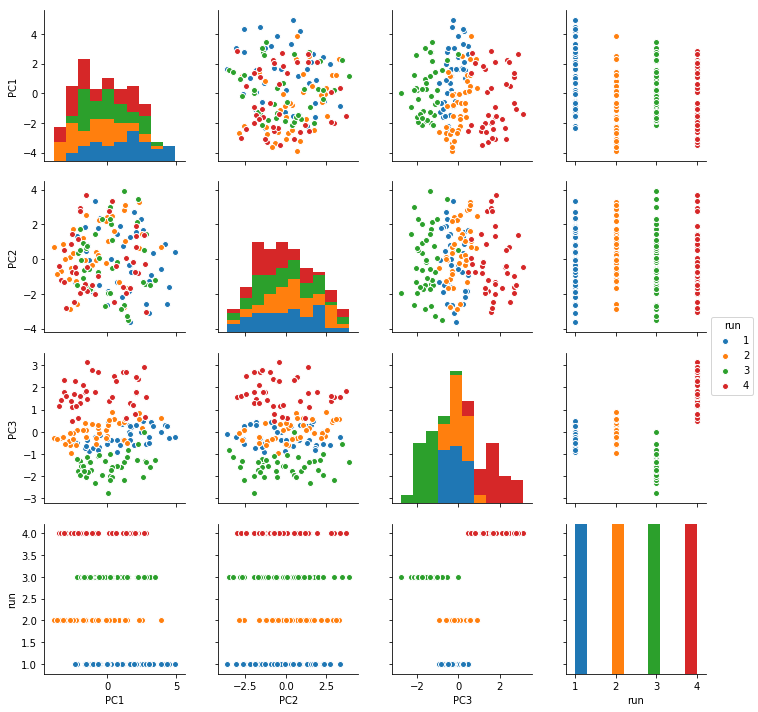

sub-106 data/sub-106/sub-106_func.nii.gz
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM

run
1    [i]
2    [a]
3    [i]
4    [a]
Name: type, dtype: object

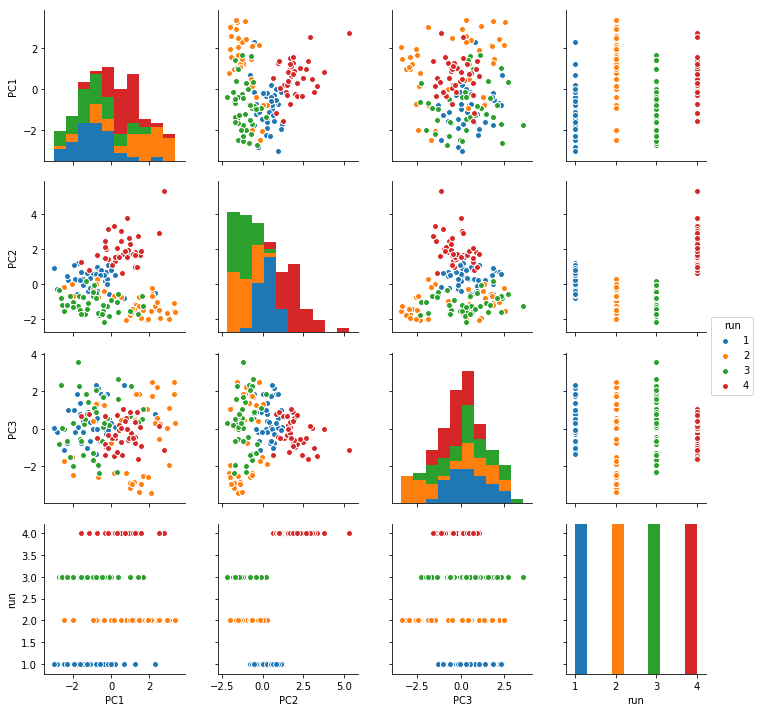

sub-112 data/sub-112/sub-112_func.nii.gz
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM

run
1    [i]
2    [a]
3    [i]
4    [a]
Name: type, dtype: object

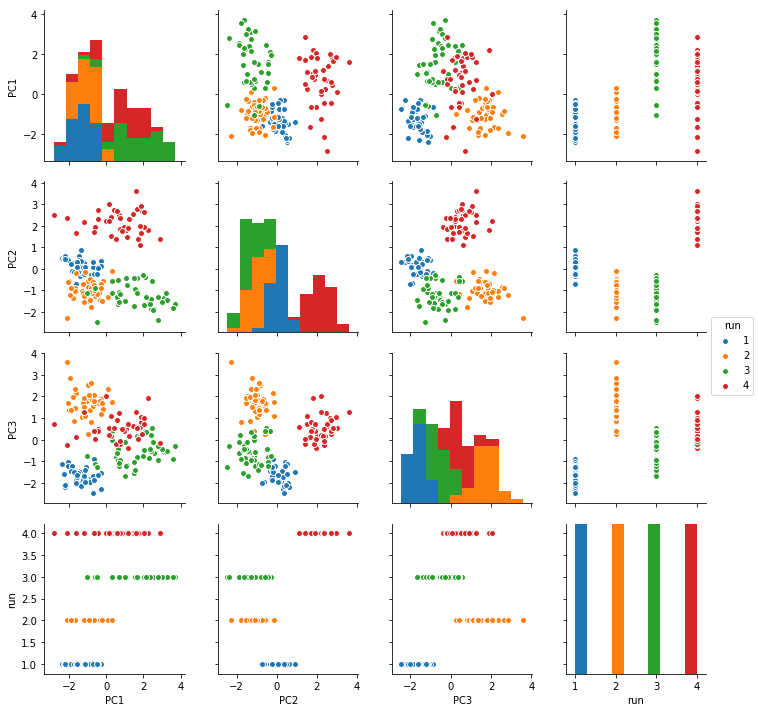

sub-125 data/sub-125/sub-125_func.nii.gz
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM

run
1    [a]
2    [i]
3    [a]
4    [i]
Name: type, dtype: object

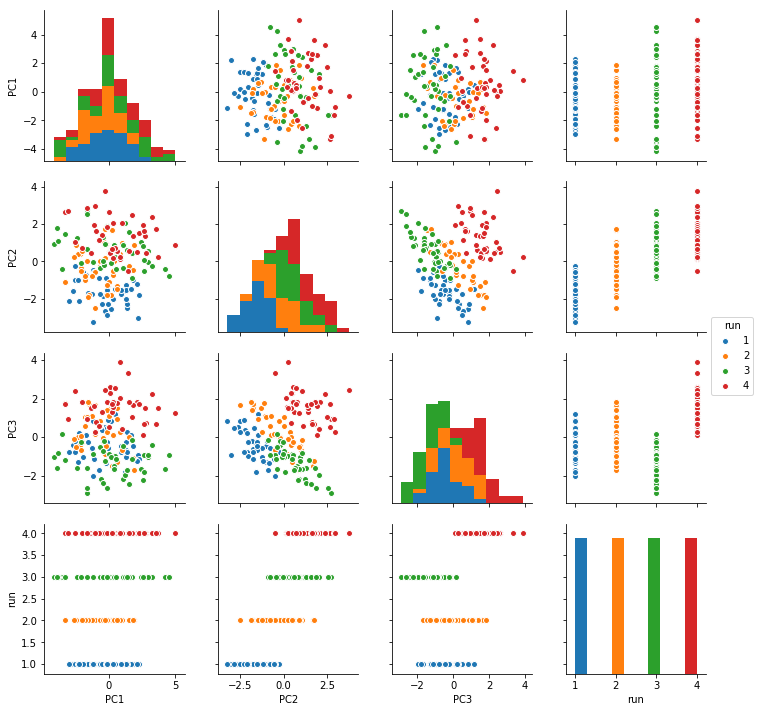

sub-123 data/sub-123/sub-123_func.nii.gz
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM

run
1    [a]
2    [i]
3    [a]
4    [i]
Name: type, dtype: object

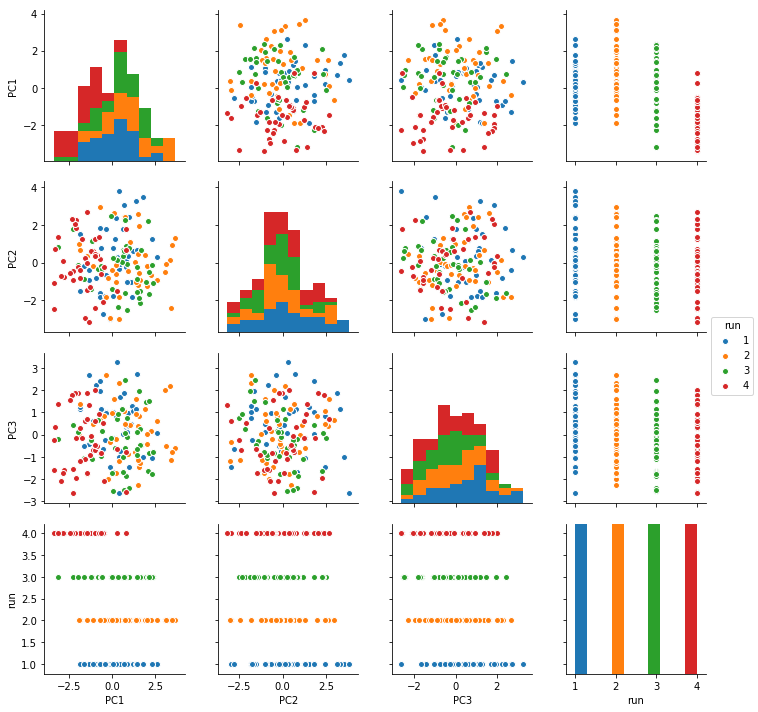

sub-108 data/sub-108/sub-108_func.nii.gz
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM

run
1    [i]
2    [a]
3    [i]
4    [a]
Name: type, dtype: object

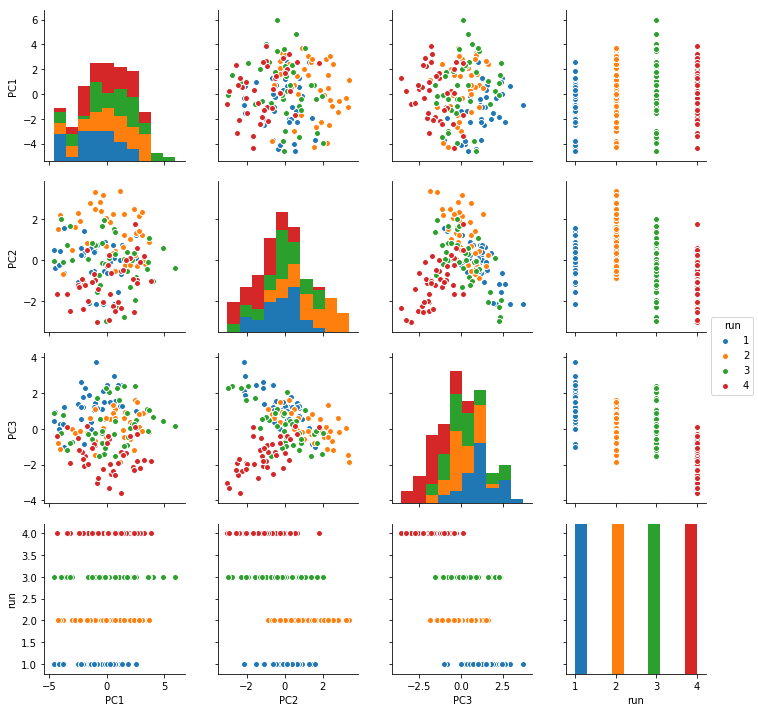

sub-111 data/sub-111/sub-111_func.nii.gz
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM

run
1    [a]
2    [i]
3    [a]
4    [i]
Name: type, dtype: object

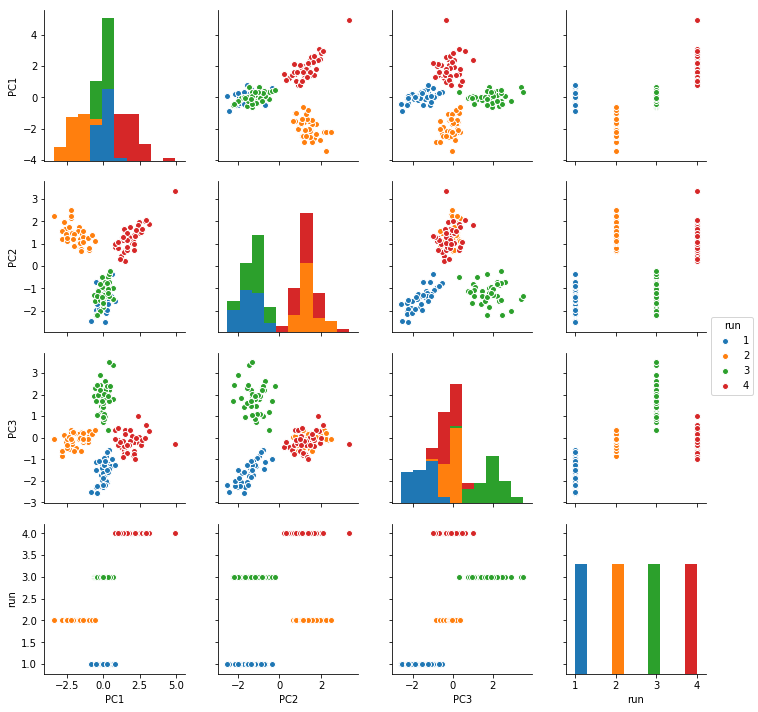

sub-115 data/sub-115/sub-115_func.nii.gz
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM

run
1    [a]
2    [i]
3    [a]
4    [i]
Name: type, dtype: object

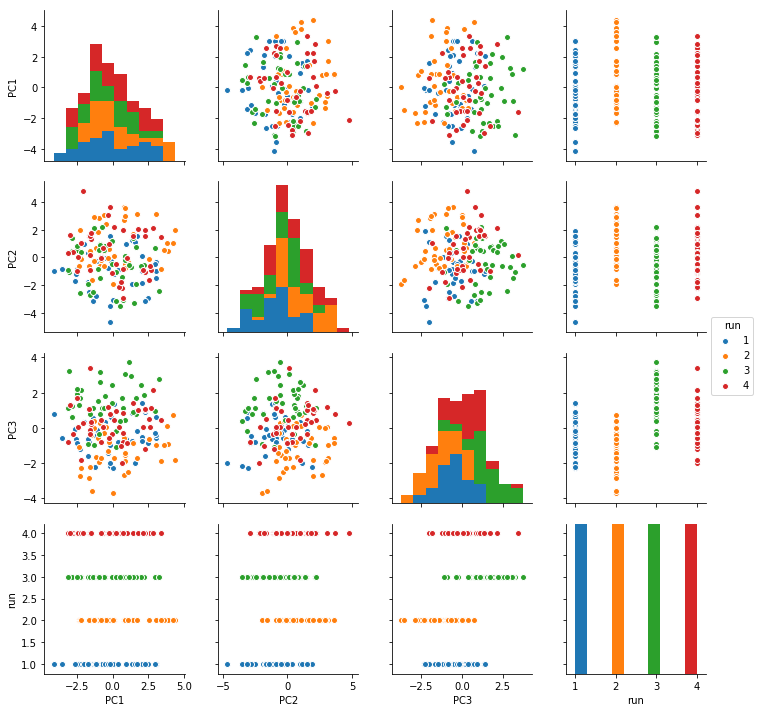

sub-117 data/sub-117/sub-117_func.nii.gz
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM

run
1    [a]
2    [i]
3    [a]
4    [i]
Name: type, dtype: object

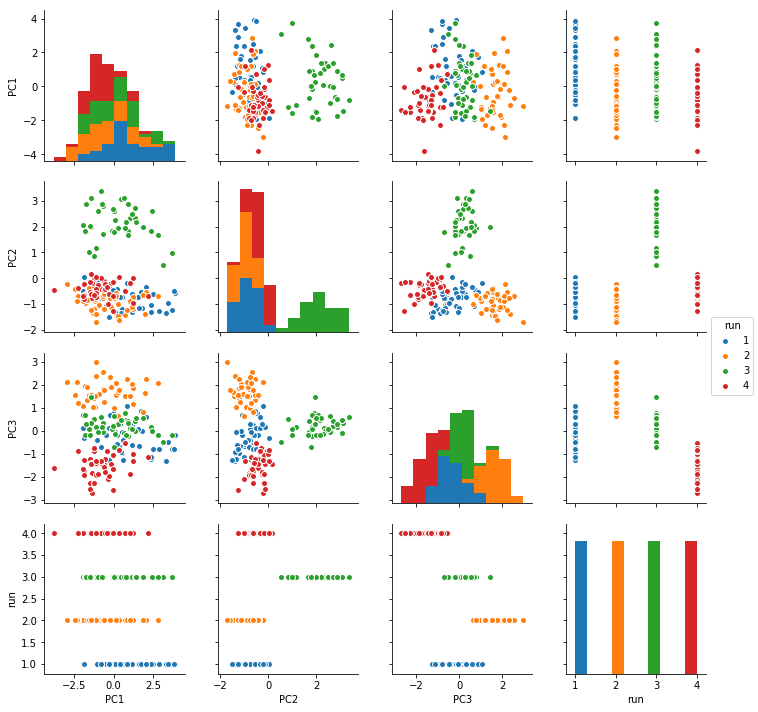

sub-120 data/sub-120/sub-120_func.nii.gz
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM

run
1    [i]
2    [a]
3    [i]
4    [a]
Name: type, dtype: object

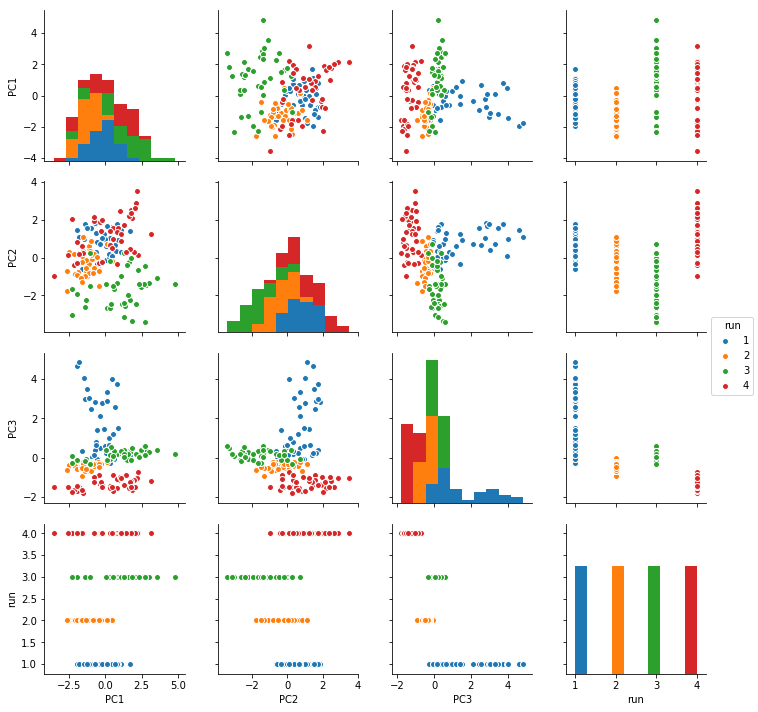

sub-116 data/sub-116/sub-116_func.nii.gz
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM

run
1    [i]
2    [a]
3    [i]
4    [a]
Name: type, dtype: object

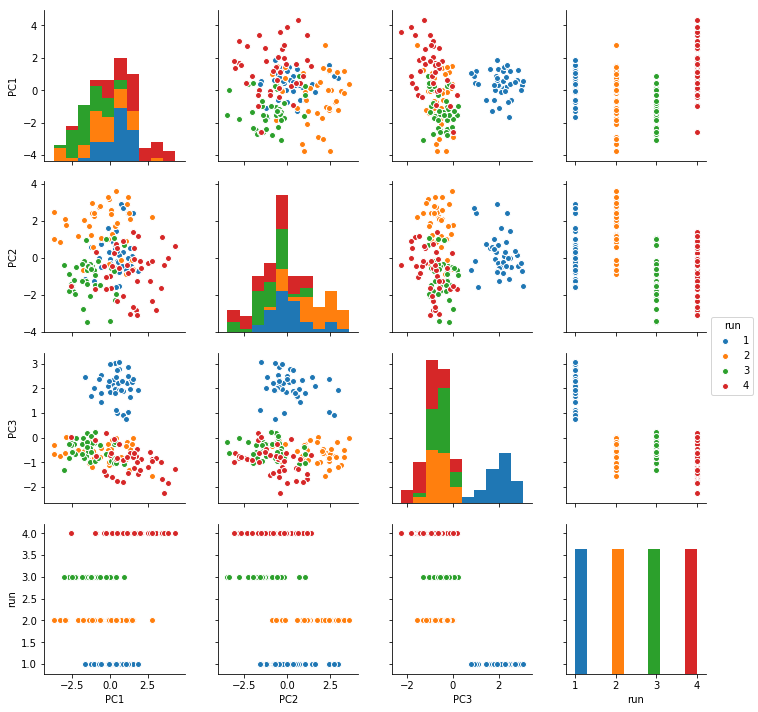

sub-114 data/sub-114/sub-114_func.nii.gz
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM

run
1    [i]
2    [a]
3    [i]
4    [a]
Name: type, dtype: object

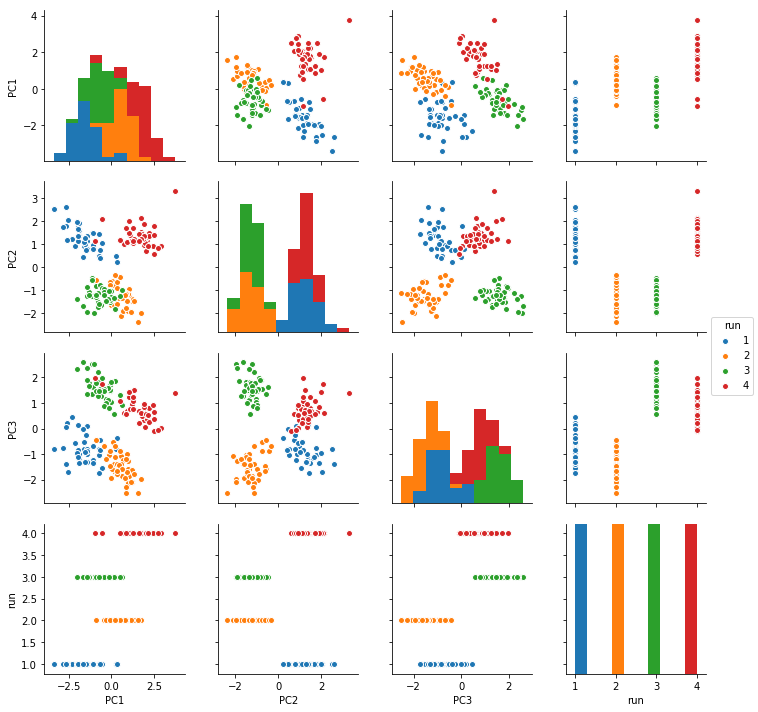

sub-109 data/sub-109/sub-109_func.nii.gz
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM

run
1    [a]
2    [i]
3    [a]
4    [i]
Name: type, dtype: object

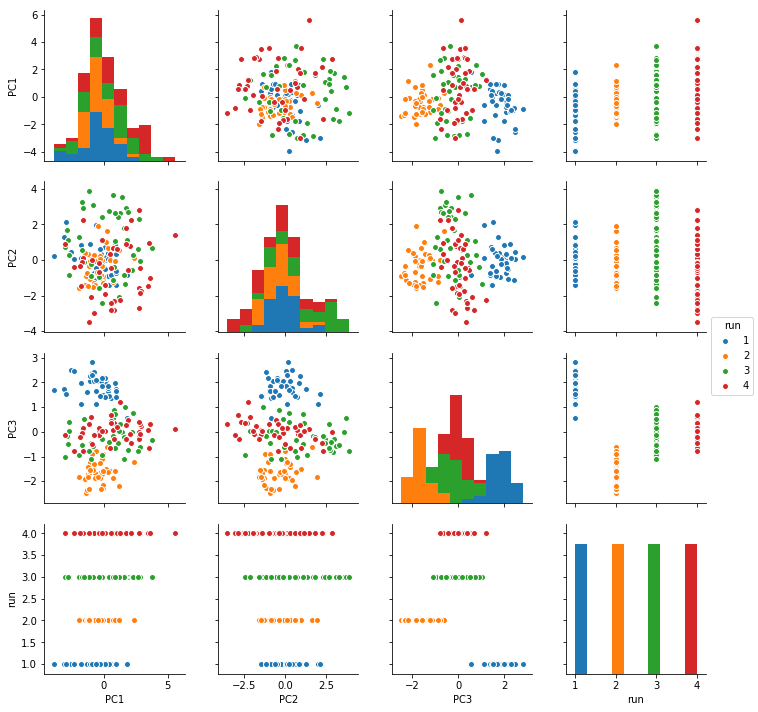

sub-121 data/sub-121/sub-121_func.nii.gz
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM

run
1    [a]
2    [i]
3    [a]
4    [i]
Name: type, dtype: object

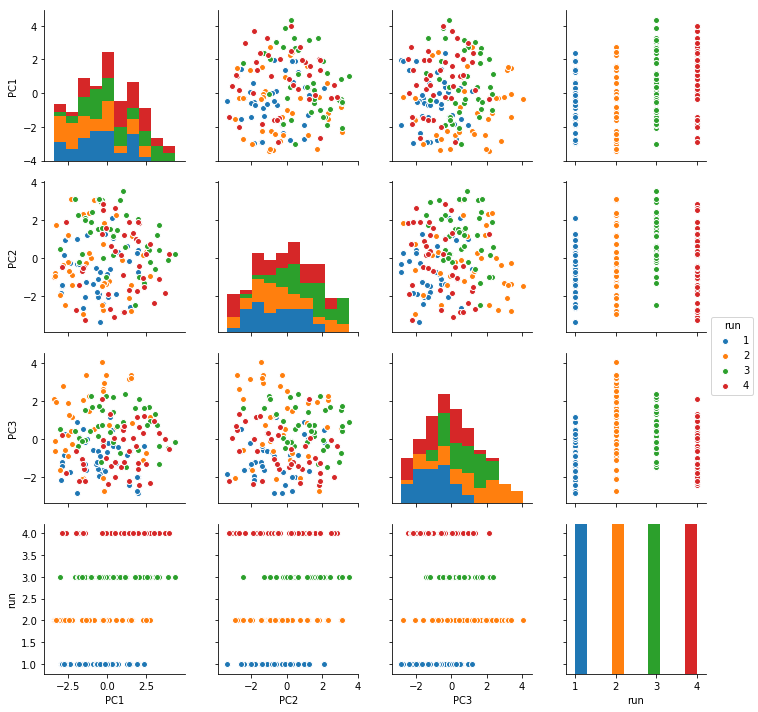

sub-122 data/sub-122/sub-122_func.nii.gz
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM

run
1    [i]
2    [a]
3    [i]
4    [a]
Name: type, dtype: object

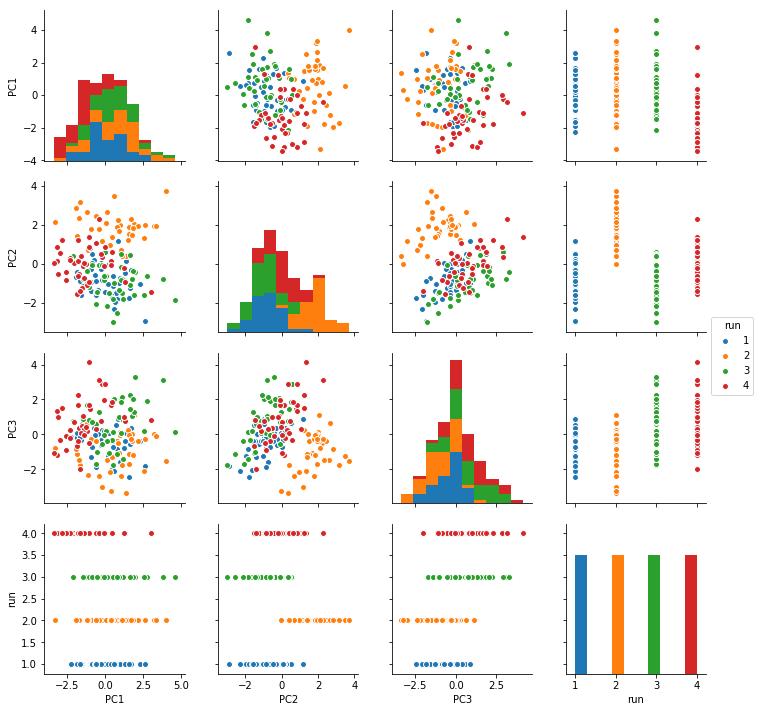

sub-104 data/sub-104/sub-104_func.nii.gz
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM

run
1    [i]
2    [a]
3    [i]
4    [a]
Name: type, dtype: object

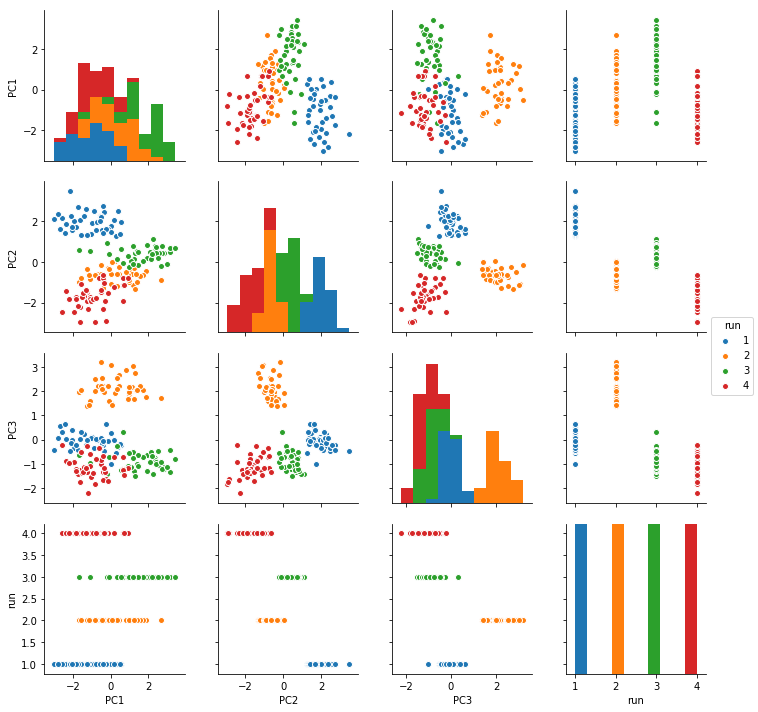

sub-110 data/sub-110/sub-110_func.nii.gz
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM

run
1    [i]
2    [a]
3    [i]
4    [a]
Name: type, dtype: object

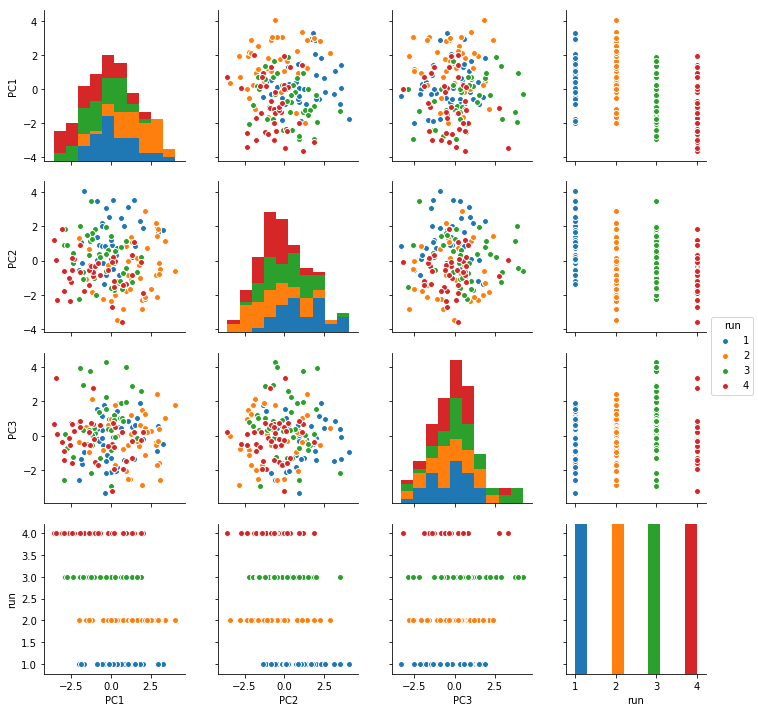

In [4]:
import sklearn
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, LeaveOneOut
import seaborn as sns

loo=LeaveOneOut()
pca=PCA(n_components=3)
cols=['sub','AOI','train_desc','test_desc','acc','train_test','train_acc']
data=[]
masker=full_pauli_masker
svc=sklearn.svm.SVC(C=1.0,
                    kernel='linear',verbose=True)

for i,sub in enumerate(sublist):
    AOI="total_striatum"
    func=image.load_img(func_list[i])
    mean_img=image.image.mean_img(func)
    print sub,func_list[i]
    behavioral = pd.read_csv('data/%s/%s_labels.csv'%(sub,sub),sep='\t')
    func_filename = func_list[i]
    
    behavioral['high_low']=behavioral.apply(lambda row: np.greater(row[3],2.5),axis=1 )
    #display(behavioral.head())
    
    
    current_masker=masker
    X = current_masker.fit_transform(func_filename)
    X=sklearn.preprocessing.normalize(X)
    X=sklearn.preprocessing.normalize(X=X, axis=0)
    X=pca.fit_transform(X)
    #don't run now normed_Xtrain=preprocessing.normalize(X_train)
    #don't run now normed_Xtest=preprocessing.normalize(X_test)        
    #Training on affective vs informative (run1 vs run2)
    # validating on affective vs informative (run3 vs run4)
    scores=cross_val_score(svc,X=X,y=behavioral.type,cv=loo)
    print np.mean(scores)
    data=pd.DataFrame({'PC1':X[:,0],'PC2':X[:,1],'PC3':X[:,2],'run':behavioral.run,'type':behavioral.type})
    display(data.groupby(by='run').type.unique())
    sns.pairplot(data=data,hue='run')
    plt.show()

    


   
    
    
    

In [5]:
df

,trial,choice,feedback,idk,type,run,high_low,quantile
NaN,0.0,1.0,2.000000,3.0,type,run,False,2
0.0,1.0,2.0,2.000000,0.0,i,1,False,2
1.0,2.0,2.0,2.000000,0.0,i,1,False,2
2.0,3.0,2.0,0.000000,1.0,i,1,False,1
3.0,4.0,2.0,0.000000,1.0,i,1,False,1
4.0,5.0,2.0,2.000000,0.0,i,1,False,2
5.0,6.0,2.0,0.000000,1.0,i,1,False,1
6.0,7.0,2.0,2.321928,0.0,i,1,False,3
7.0,8.0,2.0,2.321928,0.0,i,1,False,3
8.0,9.0,2.0,2.321928,0.0,i,1,False,3


In [6]:
df_list=[]
for i,sub in enumerate(sublist):
    current_df = pd.read_csv('data/%s/%s_labels.csv'%(sub,sub),sep='\t',index_col=0)  
    current_df.columns=['trial','deck','feedback','miss','type','run']
    current_df['high_low']=current_df.apply(lambda row: np.greater(row['feedback'],2.5),axis=1 )
    current_df['sub']=sub
    current_df['func_file']=func_list[i]
    df_list.append(current_df)
behavior_df=pd.concat(df_list)
display(behavior_df.groupby(by='sub').mean())
func_total=nilearn.image.concat_imgs(behavior_df.func_file.unique())


,trial,deck,feedback,miss,run,high_low
sub,,,,,,
sub-104,20.5,1.5,2.266802,0.00625,2.5,0.36875
sub-106,20.5,1.5,2.157056,0.01250,2.5,0.33750
sub-107,20.5,1.5,2.042930,0.07500,2.5,0.29375
sub-108,20.5,1.5,2.171495,0.08750,2.5,0.34375
sub-109,20.5,1.5,1.948780,0.11875,2.5,0.27500
sub-110,20.5,1.5,2.177176,0.05625,2.5,0.31250
sub-111,20.5,1.5,2.188496,0.01250,2.5,0.35625
sub-112,20.5,1.5,2.231569,0.01875,2.5,0.34375
sub-113,20.5,1.5,2.135176,0.03125,2.5,0.31250


In [7]:
pca=sklearn.decomposition.PCA(n_components=50)
print behavior_df.head()
func=func_total
current_masker=masker
X = current_masker.fit_transform(func)
X=pca.fit_transform(X)

#display(data.groupby(by='run').type.unique())

#sns.pairplot(data=data,hue='type')
plt.show()
print behavior_df['high_low']

   trial  deck  feedback  miss type  run  high_low      sub  \
0    1.0   1.0       3.0   0.0    a    1      True  sub-119   
1    2.0   1.0       1.0   0.0    a    1     False  sub-119   
2    3.0   1.0       2.0   0.0    a    1     False  sub-119   
3    4.0   1.0       2.0   0.0    a    1     False  sub-119   
4    5.0   1.0       2.0   0.0    a    1     False  sub-119   

                          func_file  
0  data/sub-119/sub-119_func.nii.gz  
1  data/sub-119/sub-119_func.nii.gz  
2  data/sub-119/sub-119_func.nii.gz  
3  data/sub-119/sub-119_func.nii.gz  
4  data/sub-119/sub-119_func.nii.gz  
0      True
1     False
2     False
3     False
4     False
5      True
6     False
7     False
8      True
9     False
10    False
11    False
12    False
13     True
14    False
15     True
16    False
17    False
18     True
19     True
20     True
21     True
22    False
23     True
24    False
25    False
26     True
27    False
28    False
29     True
      ...  
10    False
11     Tr

In [8]:

print behavior_df.head()
func=func_total
current_masker=masker
X = current_masker.fit_transform(func)
X=pca.fit_transform(X)
print('working')
#don't run now normed_Xtrain=preprocessing.normalize(X_train)
#don't run now normed_Xtest=preprocessing.normalize(X_test)        
#Training on affective vs informative (run1 vs run2)
# validating on affective vs informative (run3 vs run4)
scores=cross_val_score(svc,X=X,y=behavior_df.high_low,cv=20,n_jobs=20)
print np.mean(scores)
#data=pd.DataFrame({'PC1':X[:,0],'PC2':X[:,1],'PC3':X[:,2],'PC4':X[:,3],'PC5':X[:,4],'PC4':X[:,5],'PC5':X[:,6],
                   #'run':behavior_df.run,'type':behavior_df.type})
display(data.groupby(by='run').type.unique())

#sns.pairplot(data=data,hue='type')



   trial  deck  feedback  miss type  run  high_low      sub  \
0    1.0   1.0       3.0   0.0    a    1      True  sub-119   
1    2.0   1.0       1.0   0.0    a    1     False  sub-119   
2    3.0   1.0       2.0   0.0    a    1     False  sub-119   
3    4.0   1.0       2.0   0.0    a    1     False  sub-119   
4    5.0   1.0       2.0   0.0    a    1     False  sub-119   

                          func_file  
0  data/sub-119/sub-119_func.nii.gz  
1  data/sub-119/sub-119_func.nii.gz  
2  data/sub-119/sub-119_func.nii.gz  
3  data/sub-119/sub-119_func.nii.gz  
4  data/sub-119/sub-119_func.nii.gz  
working
0.665631469979296


run
1    [i]
2    [a]
3    [i]
4    [a]
Name: type, dtype: object

In [10]:
print behavior_df['high_low'].value_counts()

False    2130
True     1070
Name: high_low, dtype: int64


In [11]:
behavior_df.reset_index(drop=True,inplace=True)
scores=[]
svc=sklearn.svm.SVC(C=1.0,
                    kernel='linear')
for sub in behavior_df['sub'].unique():
    print sub
    train_index=behavior_df.index[~behavior_df['sub'].isin([sub])].tolist()
    test_index=behavior_df.index[behavior_df['sub'].isin([sub])].tolist()
    Y_train=behavior_df.iloc[train_index]
    X_train=X[train_index]
    
    Y_test=behavior_df.iloc[test_index]
    X_test=X[test_index]
    print(test_index)
    print('training subjects:', Y_train['sub'].unique())
    print('testing subject:',Y_test['sub'].unique())
    svc.fit(X_train,Y_train['high_low'])
    scores.append(svc.score(X_test,Y_test['high_low']))

sub-119
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159]
('training subjects:', array(['sub-118', 'sub-107', 'sub-113', 'sub-106', 'sub-112', 'sub-125',
       'sub-123', 'sub-108', 'sub-111', 'sub-115', 'sub-117', 'sub-120',
       'sub-116', 'sub-114', 'sub-109', 'sub-121', 'sub-122', 'sub-104',
       'sub-110'], dtype=object))
('testing subject:', arra

sub-108
[1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356, 1357, 1358, 1359, 1360, 1361, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439]
('training subjects:', array(['

sub-109
[2400, 2401, 2402, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 2410, 2411, 2412, 2413, 2414, 2415, 2416, 2417, 2418, 2419, 2420, 2421, 2422, 2423, 2424, 2425, 2426, 2427, 2428, 2429, 2430, 2431, 2432, 2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443, 2444, 2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559]
('training subjects:', array(['

In [12]:
HL_scores=scores
print np.mean(HL_scores)
print('These are the scores for cross subject classification of generic high_vs low',
      [HL_scores,behavior_df['sub'].unique()])

0.6656250000000001
('These are the scores for cross subject classification of generic high_vs low', [[0.675, 0.6625, 0.70625, 0.6875, 0.6625, 0.65625, 0.61875, 0.71875, 0.65625, 0.64375, 0.64375, 0.65625, 0.675, 0.6125, 0.675, 0.725, 0.675, 0.64375, 0.63125, 0.6875], array(['sub-119', 'sub-118', 'sub-107', 'sub-113', 'sub-106', 'sub-112',
       'sub-125', 'sub-123', 'sub-108', 'sub-111', 'sub-115', 'sub-117',
       'sub-120', 'sub-116', 'sub-114', 'sub-109', 'sub-121', 'sub-122',
       'sub-104', 'sub-110'], dtype=object)])


In [13]:
a_i_scores=[]
for sub in behavior_df['sub'].unique():
    print sub
    train_index=behavior_df.index[np.logical_and(~behavior_df['sub'].isin([sub]),
                                                 behavior_df['type'].isin(['a']))].tolist()
    test_index=behavior_df.index[np.logical_and(behavior_df['sub'].isin([sub]),
                                                behavior_df['type'].isin(['i']))].tolist()
    Y_train=behavior_df.iloc[train_index]
    X_train=X[train_index]
    print Y_train['sub'].unique()
    Y_test=behavior_df.iloc[test_index]
    X_test=X[test_index]
    print(test_index)
    print('training subjects:', Y_train['sub'].unique())
    print('testing subject:',Y_test['sub'].unique())
    svc.fit(X_train,Y_train['high_low'])
    a_i_scores.append(svc.score(X_test,Y_test['high_low']))

sub-119
['sub-118' 'sub-107' 'sub-113' 'sub-106' 'sub-112' 'sub-125' 'sub-123'
 'sub-108' 'sub-111' 'sub-115' 'sub-117' 'sub-120' 'sub-116' 'sub-114'
 'sub-109' 'sub-121' 'sub-122' 'sub-104' 'sub-110']
[40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159]
('training subjects:', array(['sub-118', 'sub-107', 'sub-113', 'sub-106', 'sub-112', 'sub-125',
       'sub-123', 'sub-108', 'sub-111', 'sub-115', 'sub-117', 'sub-120',
       'sub-116', 'sub-114', 'sub-109', 'sub-121', 'sub-122', 'sub-104',
       'sub-110'], dtype=object))
('testing subject:', array(['sub-119'], dtype=object))
sub-118
['sub-119' 'sub-107' 'sub-113' 'sub-106' 'sub-112' 'sub-125' 'sub-123'
 'sub-108' 'sub-111' 'sub-1

sub-111
['sub-119' 'sub-118' 'sub-107' 'sub-113' 'sub-106' 'sub-112' 'sub-125'
 'sub-123' 'sub-108' 'sub-115' 'sub-117' 'sub-120' 'sub-116' 'sub-114'
 'sub-109' 'sub-121' 'sub-122' 'sub-104' 'sub-110']
[1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599]
('training subjects:', array(['sub-119', 'sub-118', 'sub-107', 'sub-113', 'sub-106', 'sub-112',
       'sub-125', 'sub-123', 'sub-108', 'sub-115', 'sub-117', 'sub-120',
       'sub-116', 'sub-114', 'sub-109', 'sub-121', 'sub-122', 'sub-104',
       'sub-110'], dtype=object))
('testing subject:', array(['sub-111'], d

sub-104
['sub-119' 'sub-118' 'sub-107' 'sub-113' 'sub-106' 'sub-112' 'sub-125'
 'sub-123' 'sub-108' 'sub-111' 'sub-115' 'sub-117' 'sub-120' 'sub-116'
 'sub-114' 'sub-109' 'sub-121' 'sub-122' 'sub-110']
[2880, 2881, 2882, 2883, 2884, 2885, 2886, 2887, 2888, 2889, 2890, 2891, 2892, 2893, 2894, 2895, 2896, 2897, 2898, 2899, 2900, 2901, 2902, 2903, 2904, 2905, 2906, 2907, 2908, 2909, 2910, 2911, 2912, 2913, 2914, 2915, 2916, 2917, 2918, 2919, 2960, 2961, 2962, 2963, 2964, 2965, 2966, 2967, 2968, 2969, 2970, 2971, 2972, 2973, 2974, 2975, 2976, 2977, 2978, 2979, 2980, 2981, 2982, 2983, 2984, 2985, 2986, 2987, 2988, 2989, 2990, 2991, 2992, 2993, 2994, 2995, 2996, 2997, 2998, 2999]
('training subjects:', array(['sub-119', 'sub-118', 'sub-107', 'sub-113', 'sub-106', 'sub-112',
       'sub-125', 'sub-123', 'sub-108', 'sub-111', 'sub-115', 'sub-117',
       'sub-120', 'sub-116', 'sub-114', 'sub-109', 'sub-121', 'sub-122',
       'sub-110'], dtype=object))
('testing subject:', array(['sub-104'], d

In [14]:
print(a_i_scores)
print(np.mean(a_i_scores))

[0.6, 0.625, 0.725, 0.7125, 0.5, 0.3375, 0.6375, 0.5625, 0.65, 0.45, 0.6625, 0.4625, 0.45, 0.725, 0.5375, 0.325, 0.575, 0.475, 0.5875, 0.8125]
0.5706249999999999


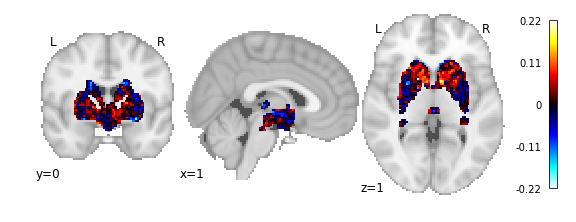

In [15]:
weights=svc.coef_
weight_img=pca.inverse_transform(weights)
weight_img=masker.inverse_transform(weight_img)
weight_img.to_filename('SVM_coef_trAHLteIHL_.nii')
plotting.plot_stat_map(weight_img,draw_cross=False,display_mode='ortho')

In [16]:
np.percentile([10,7,4,3,2,1],50)


3.5